Execution time = 585.8381485939026 seconds



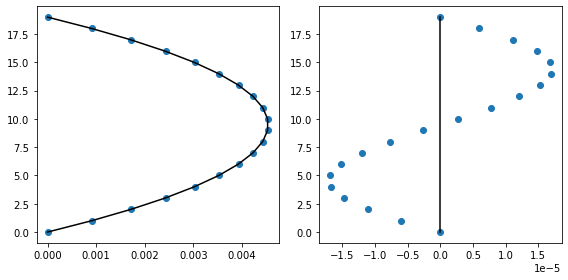

In [4]:
# created by Nicole Neumann and Kent Ridl
# LBM Mid-Grid Bounce Back D2Q9 Poiseuille flow

import numpy as np
import matplotlib.pyplot as plt
import time


scale = 1
Nx = 202
Ny = 22
delta = .5 #mid-grid scaling 
H = Ny - 3 #- 2*delta #height of channel leaving room for buffer node
Nt = 2500 #time steps
v = 9 #number of velocities
vmap = range(0,v,1)
tau = float(.798) #relaxation time for advection dominated problem 
dpdx = 1e-05
rho0 = 1
cs = np.sqrt(1/3) #speed of sound in lattice units 
V = cs**2*(tau-.5) # kinematic viscosity 
cx = [0, 1, 0, -1, 0, -1, 1, -1, 1] # x direction velocities
cy = [0, 0, 1, 0, -1, 1, 1, -1, -1] # y direction velocities 
w = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36] # weights of discrete velocity (ci)
kb = [0, 3, 4, 1, 2, 8, 7, 6, 5]    # value of each spot is the index of the reciprocal velocity component
isn=np.zeros((Nx,Ny)) # 1 is solid 0 is fluid

f=np.zeros((v,Nx,Ny)) 
ft=np.zeros((v,Nx,Ny))
term1=np.zeros((v,Nx,Ny))
term2=np.zeros((v,Nx,Ny))

ux=np.zeros((Nx,Ny))
uy=np.zeros((Nx,Ny))
u2=np.zeros((Nx,Ny))
rho=np.zeros((Nx,Ny))
source=np.zeros((Nx,Ny))
feq=np.zeros((Nx,Ny))
onemat=np.ones((Nx,Ny))

momentx=[]
momenty=[]
height=[]


tic = time.time()


for i in range(0,Nx,1):
    for j in range(0,Ny,1):
        if j == 0 or j == Ny-1:
            isn[i][j]=1 # solid node
        else:
            isn[i][j]=0 #fluid
        f[:,i,j]= [w[k]*rho0 for k in vmap]

for t in range(1,Nt+1,1):
    for i in range(0,Nx,1):
        for j in range(1,Ny-1,1):   # indexing to only care about fluid nodes
            rho[i,j] = np.sum(f[:,i,j],axis=0)                                           # 0th moment
            ux[i,j] = (np.sum([f[k,i,j]*cx[k] for k in vmap]) + 0.5*dpdx) / rho[i,j]     # 1st moment, x-component, plus PGF forcing
            uy[i,j] = np.sum([f[k,i,j]*cy[k] for k in vmap]) / rho[i,j]                  # 1st moment, y-component
            
    u2 = np.multiply(ux,ux) + np.multiply(uy,uy)     
    term1 = np.array([ux*cx[k] + uy*cy[k] for k in vmap])
    term2 = np.multiply(term1,term1)
    source = np.array([(1.0-0.5/tau)*w[k]*(3*(cx[k]-ux)+9*(cx[k]*ux+cy[k]*uy)*cx[k])*dpdx for k in vmap])
    feq = np.array([w[k]*rho*(onemat+3*term1[k]+4.5*term2[k]-1.5*u2) for k in vmap])
    ft = np.array([f[k] - (f[k]-feq[k])/tau + source[k] for k in vmap])
                
    # Streaming step
    # Periodicity exists only along x-axis, so only wrap around there
    f[1,:,1:-1] = np.roll(ft[1,:,1:-1],[1,0],axis=(0,1))
    f[2,:,1:-1] = np.roll(ft[2,:,1:-1],[0,1],axis=(0,1))
    f[3,:,1:-1] = np.roll(ft[3,:,1:-1],[-1,0],axis=(0,1))
    f[4,:,1:-1] = np.roll(ft[4,:,1:-1],[0,-1],axis=(0,1))
    f[5,:,1:-1] = np.roll(ft[5,:,1:-1],[-1,1],axis=(0,1))
    f[6,:,1:-1] = np.roll(ft[6,:,1:-1],[1,1],axis=(0,1))
    f[7,:,1:-1] = np.roll(ft[7,:,1:-1],[-1,-1],axis=(0,1))
    f[8,:,1:-1] = np.roll(ft[8,:,1:-1],[1,-1],axis=(0,1))
                
    # Bounce back
    for i in range(0,Nx,1):
        for j in range(0,Ny,1):
            if isn[i][j] == 0: # look at fluid nodes... 
                for k in vmap:
                    ia = i - cx[k]  # adjust indices to look if fluid node has a solid neighbor
                    ja = j - cy[k]
                    if ia < 0: #periodicity along x-axis
                        ia = Nx-1
                    elif ia > Nx-1:
                        ia = 0
                    if isn[ia][ja] == 1:    # neighbor is a solid node
                        oppV = int(kb[k])
                        f[k][i][j] = f[oppV][i][j]
                        
                        
print("Execution time =", time.time() - tic, "seconds\n")
                            

# Generate theory curve
ux_exact = [0] * (Ny-2) # want 20 spaces for 20 fluid lattice nodes
for j in range(0,Ny-2,1):   # indices 0-19 gives 20 nodes
    y = j/H  
    y2 = y*y
    ux_exact[j]= 0.5*dpdx*H*H*(y-y2)/V
    height.append(j)

# Collect LB data results to compare to theory
i=Nx-1  # looking at outlet
for j in range(1,Ny-1,1):   # want just the 20 fluid nodes from f, given by indices 1-20
    rho=0.0
    ux=0.0 
    uy=0.0
    for k in vmap:
        rho += f[k][i][j]
        ux += f[k][i][j] * cx[k]
        uy += f[k][i][j] * cy[k]
    ux /= rho
    uy /= rho
    momentx.append(ux)
    momenty.append(uy)  
#verify the model
fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(8,4))
ax[0].scatter(momentx,height)
ax[0].plot(ux_exact,height,'k')
ax[1].scatter(momenty,height)
ax[1].plot([0,0],[0,19],"k")
plt.tight_layout();
plt.show()
               